In [51]:
import json
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import random
import pandas as pd
from tqdm import tqdm
import dataclasses
from funcy import lmap, lfilter


plt.style.use("_mpl-gallery")

In [52]:
with open("data/source/all.jsonl", "r") as fp:
    lines = fp.readlines()

with Pool() as p:
    objs = p.map(json.loads, lines)

langs = ["python", "java", "go", "cpp", "js"]

In [53]:

objss = lmap(lambda l: lfilter(lambda o: o["lang"] == l, objs), langs)



In [60]:
js_objs = objss[-1]
js_objs[0]

{'test_id': "1999-sklad/1999-sklad-0ca58f1/tests/get.js::'Get operations in one store'",
 'test': "function () {\n        var arr = 'Hi my name is my name is my name is Slim Shady'.split(' ');\n        var forumUsers = [\n            {name: 'Dmitry', login: '1999'},\n            {name: 'Alex', login: 'Skiller'},\n            {name: 'Anton', login: 'Clon'},\n            {name: 'Leonid', login: 'Dollars'},\n            {name: 'Denis', login: 'win32'},\n            {name: 'Sergey', login: 'bizkid-e-burg'},\n            {name: 'Roman', login: 'Backenbart'},\n            {name: 'Alex', login: 'Yarex'},\n            {name: 'Anton', login: 'ukkk'}\n        ];\n\n        var arrUniqueSorted = arr.reduce(function (previousValue, currentValue) {\n            if (previousValue.indexOf(currentValue) === -1) {\n                previousValue.push(currentValue);\n            }\n\n            return previousValue;\n        }, []).sort();\n\n        beforeEach(function (done) {\n            conn.insert

# Test-to-function Ratio

In [54]:
def repo_id(test_id: str) -> str:
    return test_id.split("/")[0]


@dataclasses.dataclass
class ProjStat:
    repo_id: str
    n_test_lines: int
    n_code_lines: int
    n_assert: int

In [81]:
def analyze(objs: list[dict]) -> pd.DataFrame:
    proj_map: dict[str, ProjStat] = {}
    for obj in tqdm(objs):
        repo = repo_id(obj["test_id"])
        test: str = obj["test"]
        code: str = obj["code"]
        n_test_lines = len(test.splitlines())
        n_code_lines = len(code.splitlines())
        
        lower_test = test.lower()
        n_assert = lower_test.count("assert")
        if obj["lang"] in ("js", "cpp"):
            n_expect = lower_test.count("expect")
            n_assert += n_expect
            if obj["lang"] == "js":
                n_test = lower_test.count("test")
                n_assert += n_test

        if repo in proj_map:
            proj_map[repo].n_test_lines += n_test_lines
            proj_map[repo].n_code_lines += n_code_lines
            proj_map[repo].n_assert += n_assert
        else:
            proj_map[repo] = ProjStat(repo, n_test_lines, n_code_lines, n_assert)
    return pd.DataFrame([o.__dict__ for o in proj_map.values()])

In [82]:
dfs = lmap(analyze, objss)

100%|██████████| 13293/13293 [00:00<00:00, 38447.35it/s]


In [56]:
def test_to_code_ratio(df: pd.DataFrame):
    return df["n_test_lines"] / df["n_code_lines"]

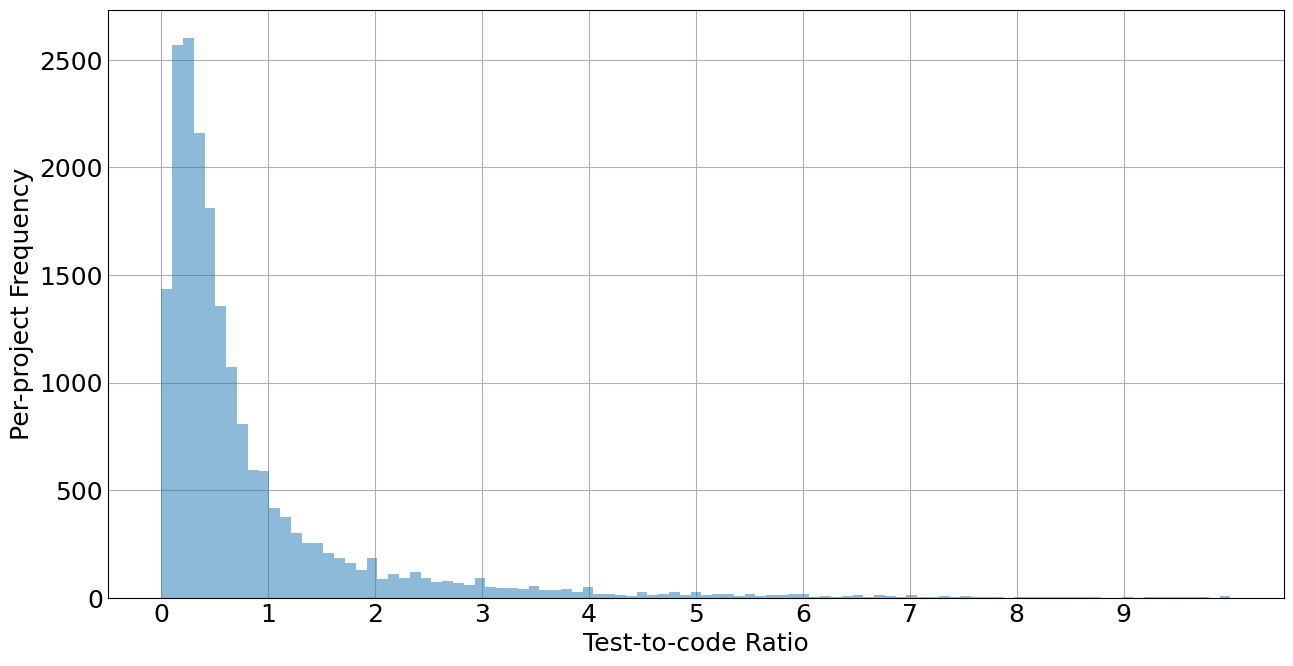

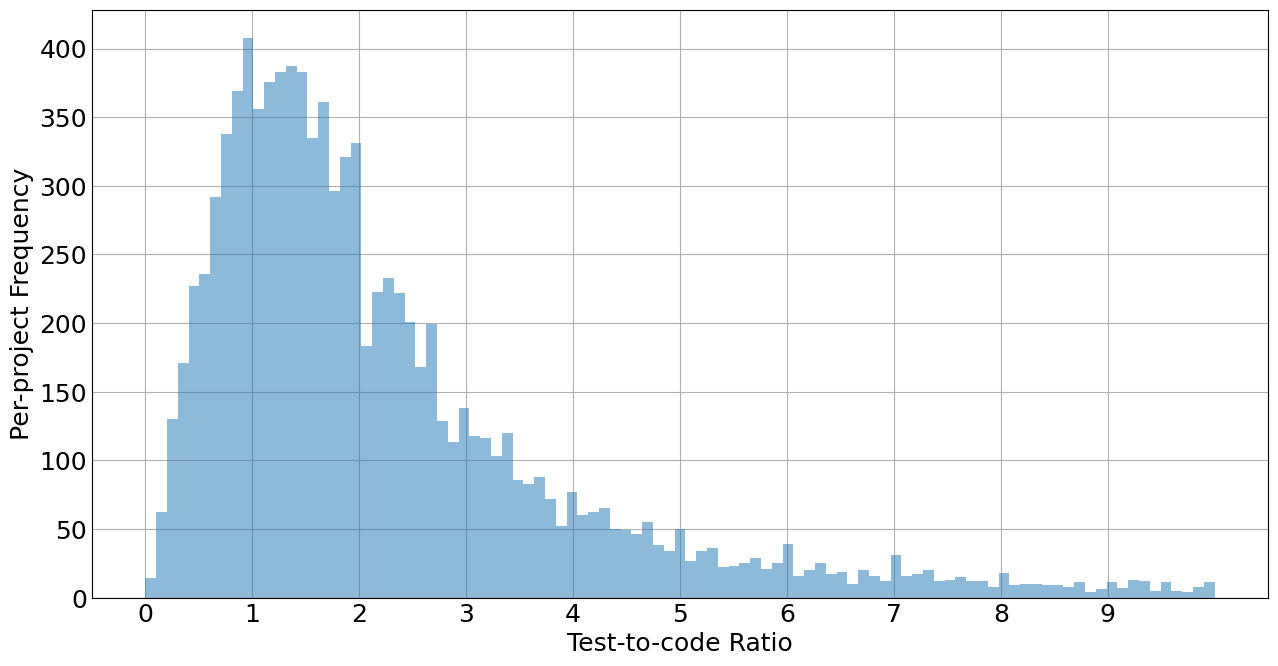

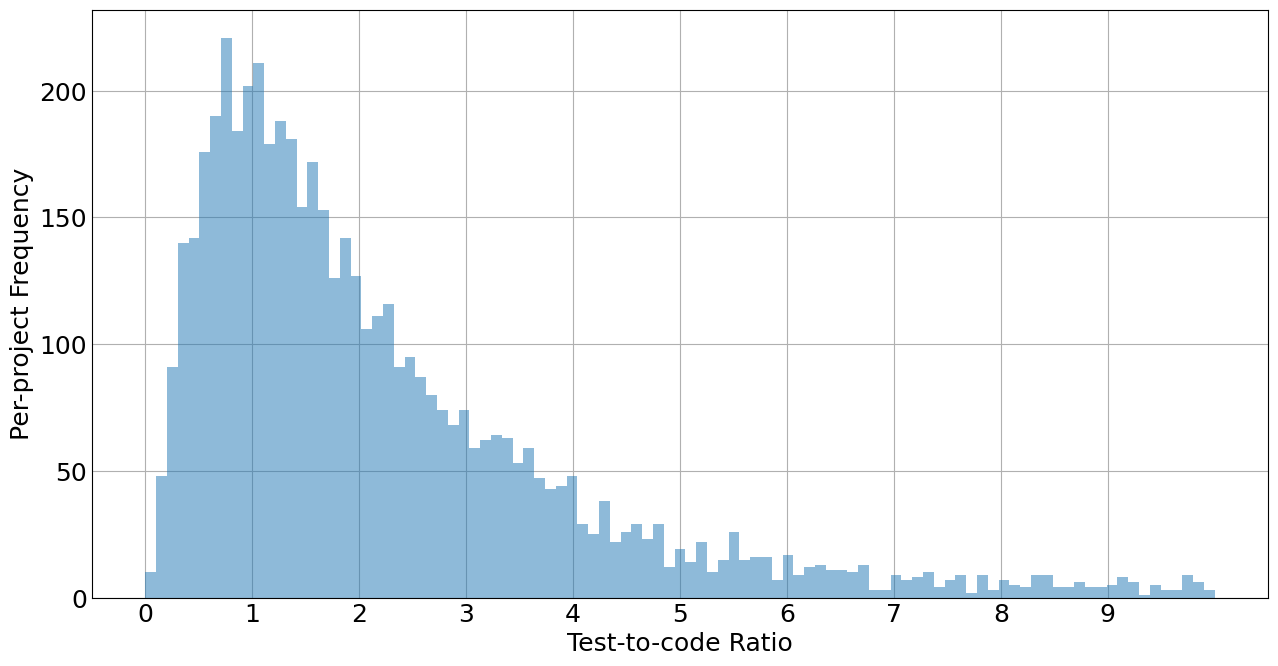

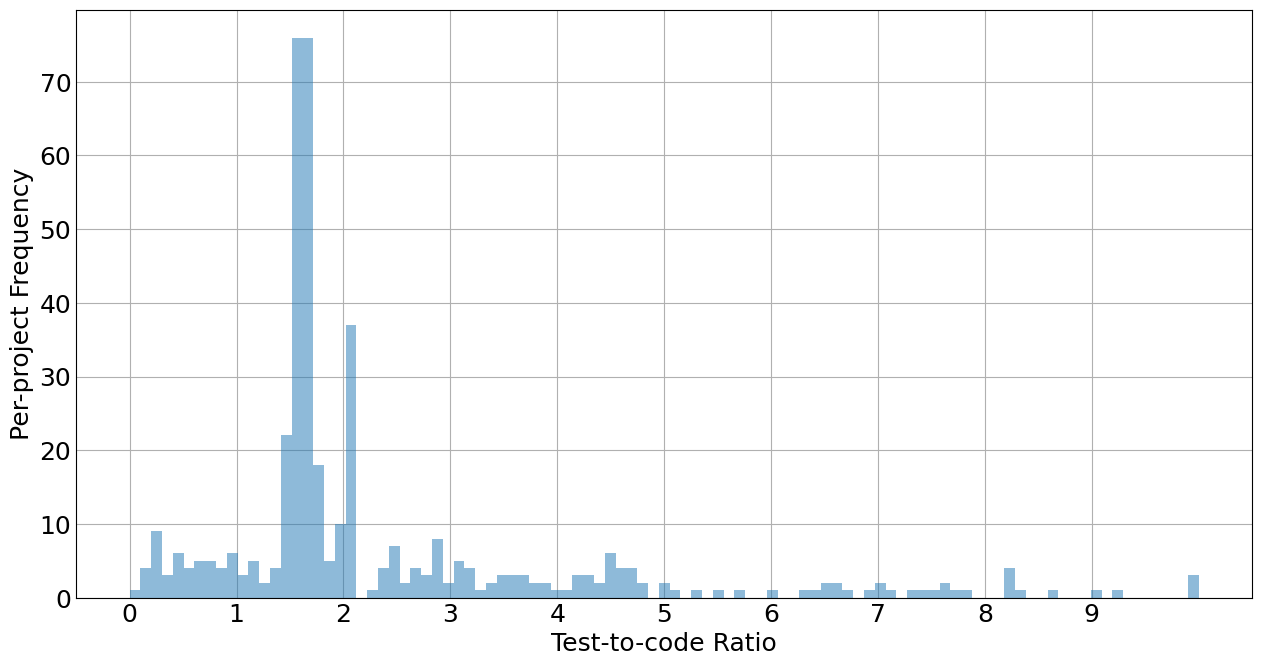

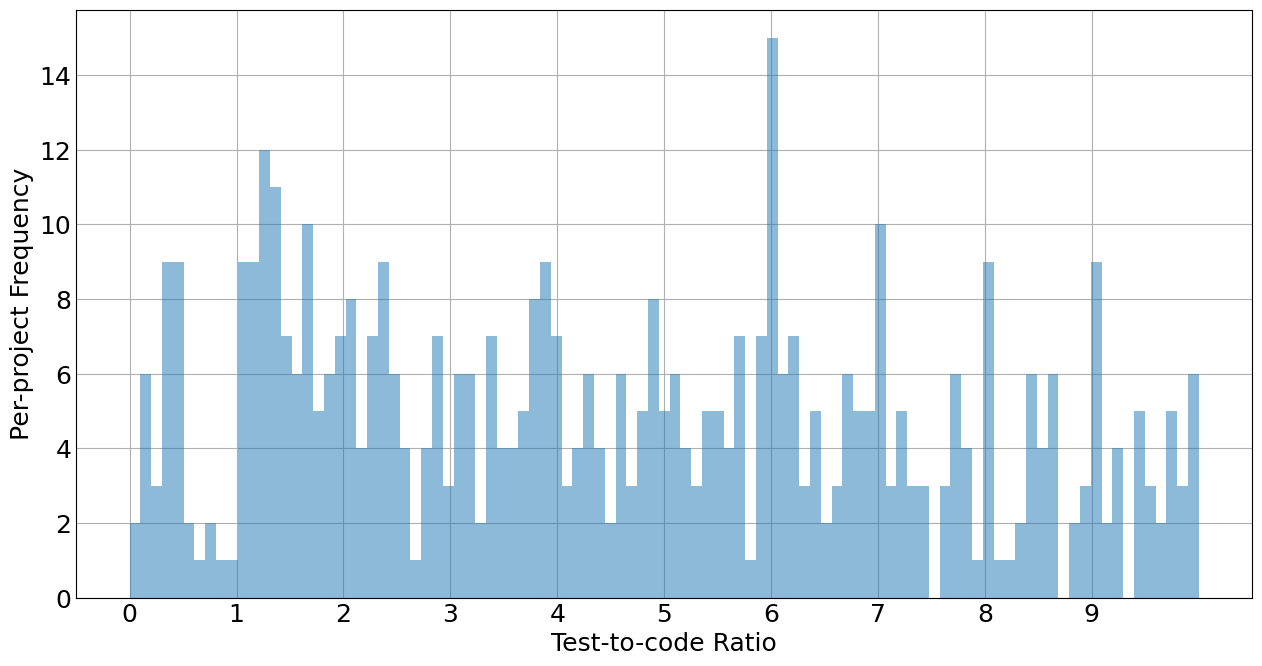

In [57]:
np.random.seed(0)
bins = np.linspace(0, 10, 100)

ratios = lmap(test_to_code_ratio, dfs)
ticks = list(range(10))
for name, ratio in zip(langs, ratios):
    plt.figure(figsize=(12,6))
    plt.hist(ratio, bins, alpha=0.5)
    plt.xticks(ticks)
    plt.xlabel("Test-to-code Ratio", fontsize=18)
    plt.ylabel("Per-project Frequency", fontsize=18)
    plt.rc('axes', labelsize=18)
    plt.savefig(f"{name}.pdf", dpi=500, bbox_inches="tight")


# Coverage

In [30]:
with open("python_coverage.jsonl", "r") as fp:
    covs = list(map(json.loads, fp.readlines()))

len(covs)

130

In [31]:
cov_df = pd.DataFrame(covs)
cov_df.describe()

,coverage
count,130.000000
mean,73.692308
std,26.756104
min,1.000000
25%,63.000000
50%,84.000000
75%,92.000000
max,100.000000


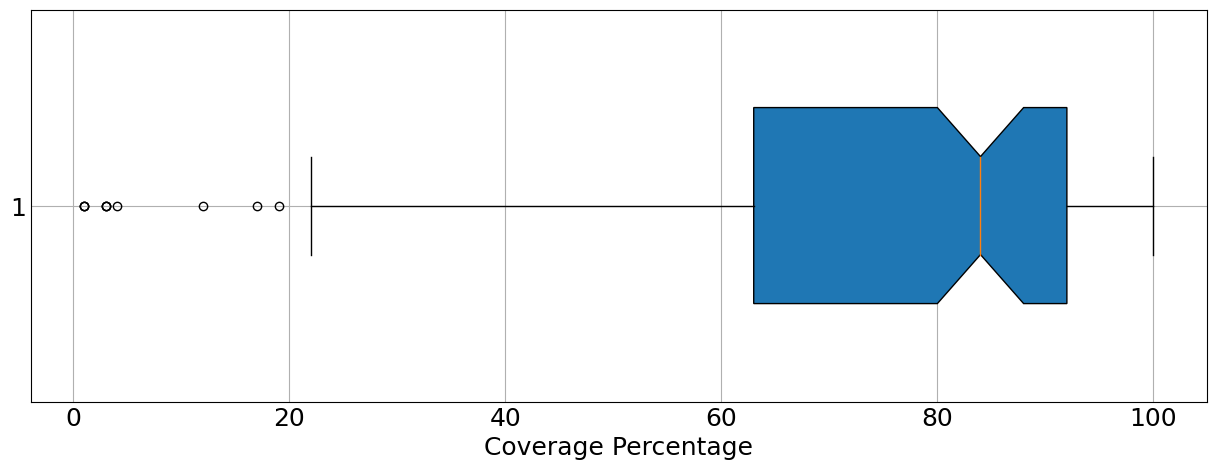

In [44]:
plt.figure(figsize=(12,4))
plt.boxplot(cov_df["coverage"], patch_artist = True, vert=False, widths=0.5, notch=True)
plt.xlabel("Coverage Percentage", fontsize=18)
plt.rc('axes', labelsize=18)

plt.savefig(f"coverage_box.pdf", dpi=500, bbox_inches="tight")

# Assertion density

In [83]:
def get_density(df: pd.DataFrame):
    return df["n_assert"] / df["n_test_lines"]


ds = list(map(get_density, dfs))

python
java
go
cpp
js


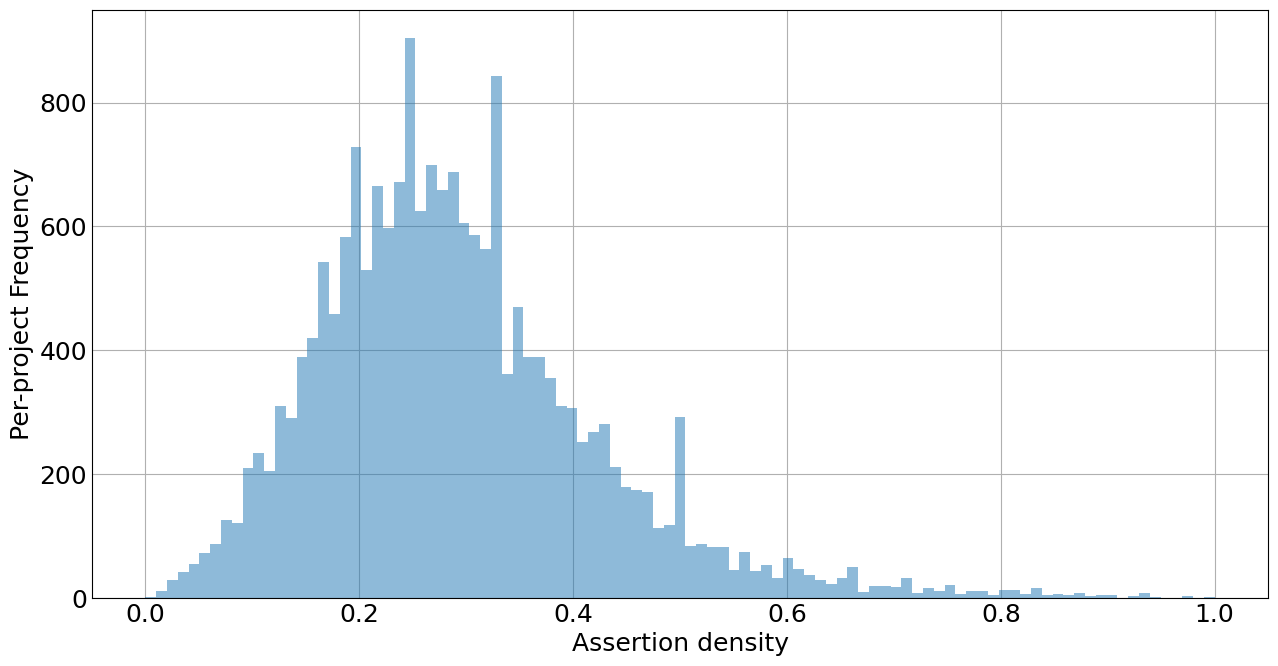

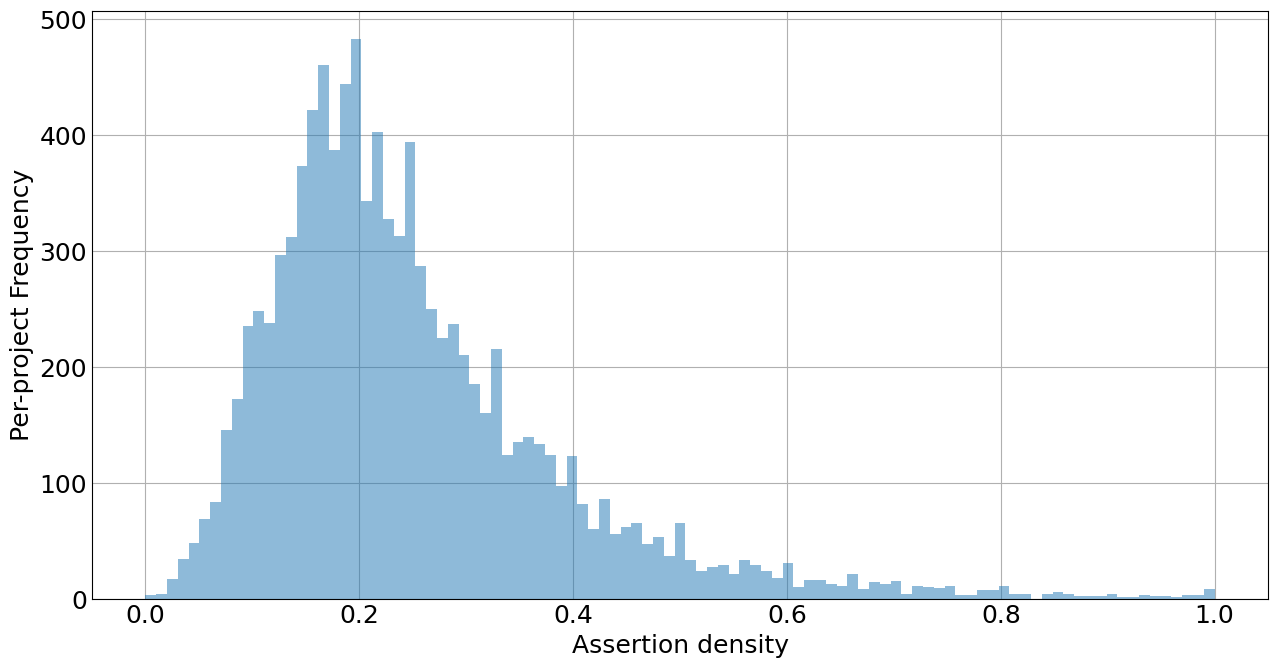

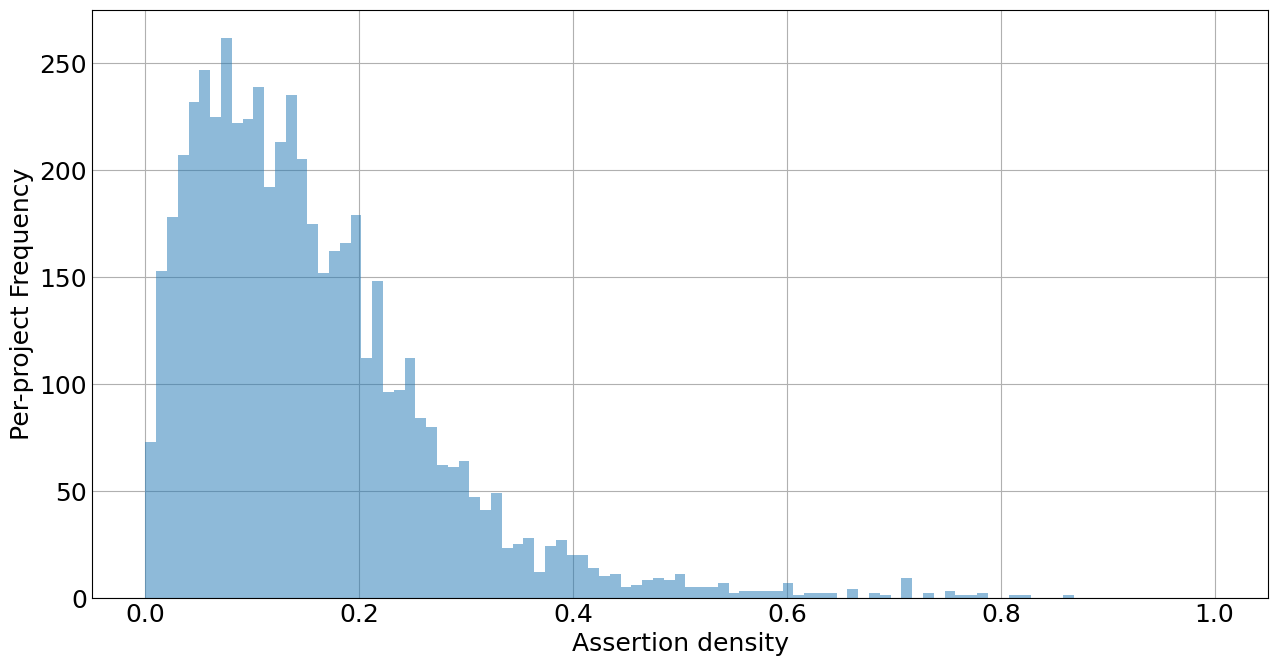

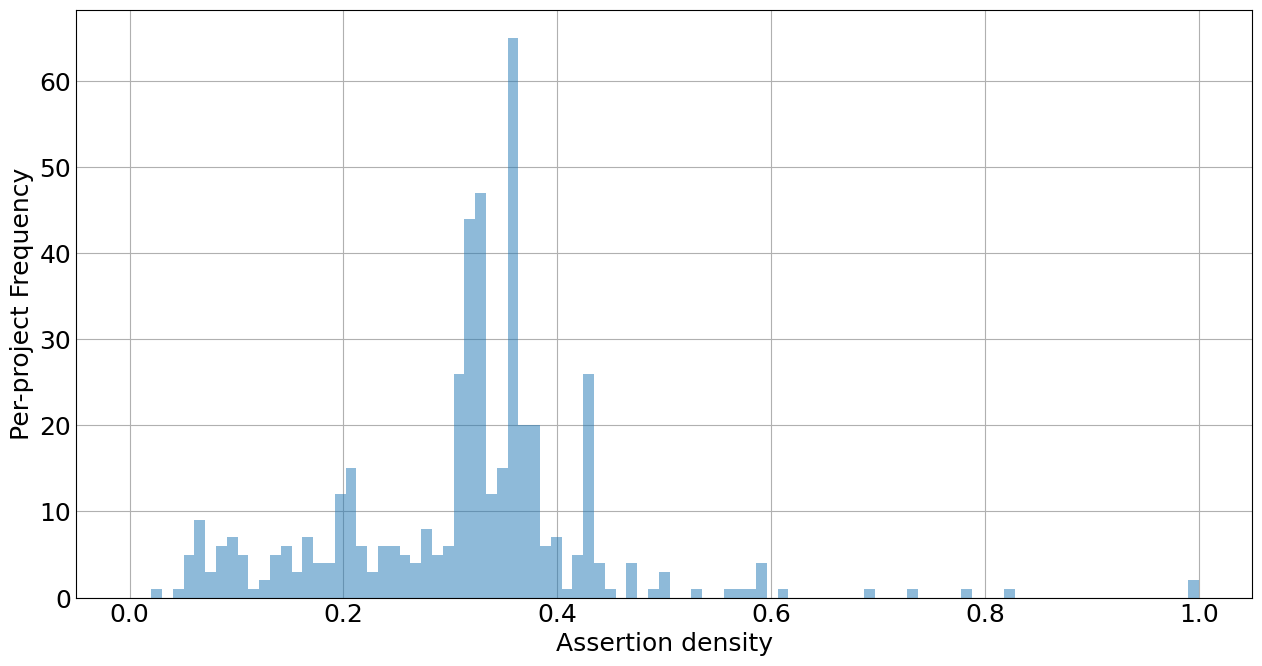

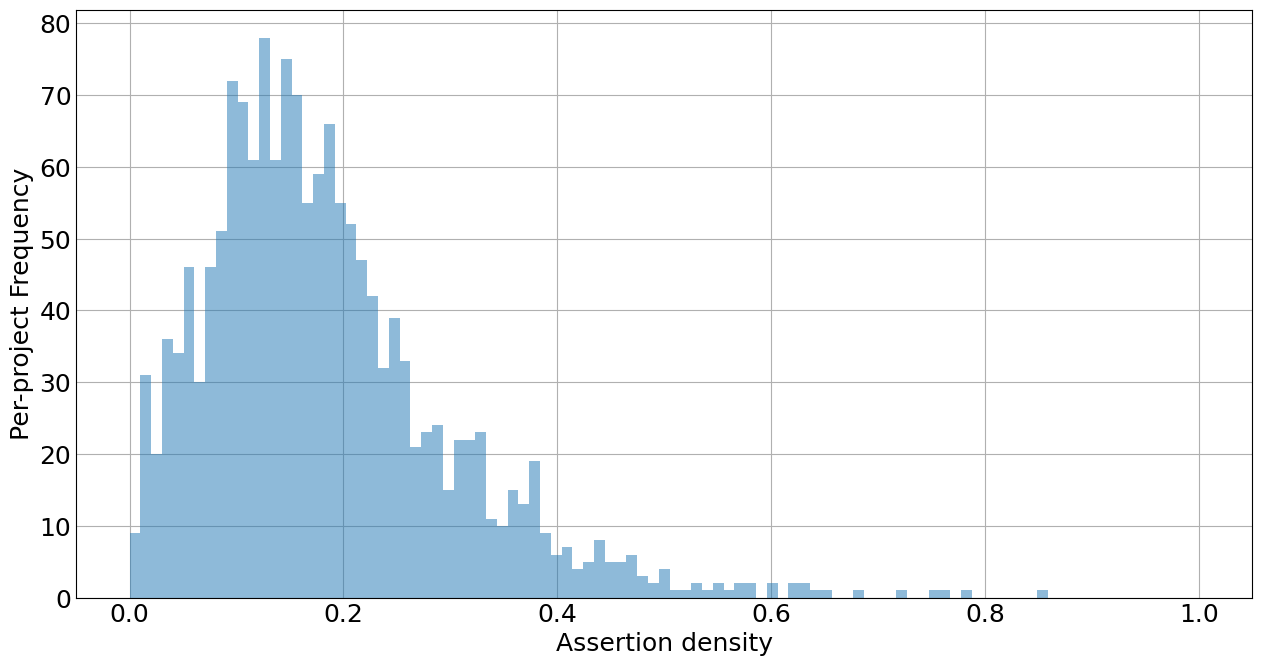

In [84]:
bins = np.linspace(0, 1, 100)
for name, density in zip(langs, ds):
    print(name)
    plt.figure(figsize=(12,6))
    plt.hist(density, bins, alpha=0.5)
    # plt.legend(loc='upper right', fontsize=18)
    # plt.yscale("log")
    plt.xlabel("Assertion density", fontsize=18)
    plt.ylabel("Per-project Frequency", fontsize=18)
    plt.rc('axes', labelsize=18)
    plt.savefig(f"density/{name}.pdf", dpi=500, bbox_inches="tight")

# Test per function

In [ ]:
counter = {}
for o in objs:
    k = o["code"]
    v = o["test"]
    if k in counter:
        counter[k] += 1
    else:
        counter[k] = 0

len(counter.keys())

In [ ]:
mult_cnt = 0
for k, v in counter.items():
    if v > 1:
        mult_cnt += 1

mult_cnt

In [ ]:
mult_cnt / len(counter.keys())

# Focal-test alignment accuracy

In [ ]:
random.seed(0)
sampled = random.sample(py_objs, 100)
len(sampled)

In [ ]:
for i, s in enumerate(sampled):
    with open(f"samples/pair_{i}.py", "w+") as fp:
        fp.write(f"# sample id {i+1}\n")
        fp.write(s["code"])
        fp.write("\n")
        fp.write(s["test"])